## Control models
Here we obtain predictors from some control models. We want to check whether these are able to explain participant choices as well as the main models we investigate in the paper. These models are the following:

* A temporal model with scrambled exploration runs
    We want to make sure that the temporal covariances of individual exploration runs best fit the subjects that produced them
    and not vice versa. This would lend credence to our claim that specific temporal covariances play a part in explaining generalization.
  
* A compositional model with an identity matrix component rather than a temporal component.
    We want to make sure that the temporal component in the compositional model brings something to the table, and that the superior fit of
    the compositional model isn't due to unforeseen numerical reasons from the kernel composition.

In [31]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import scipy
import scipy.stats
import networkx as nx
import pandas as pd
import pickle
from MonsterPrior import MonsterPrior
from importlib import reload
from pathlib import Path
from utils import * 
from SuccessorRepresentation import SuccessorRepresentation
from GraphGP import LaplacianGP
import copy
import time
%matplotlib inline 
# for jupyter notebook

### Open pickled files

with open('transitions.pickle', 'rb') as handle:
    transition_dict = pickle.load(handle)


with open('path_integration_kernels.pickle', 'rb') as handle:
    estimated_euclidean_kernels = pickle.load(handle)

with open('path_integration_monster_locations.pickle', 'rb') as handle:
    PI_dict = pickle.load(handle)


### Unpack and process these things into a dictionary which we we'll during the analysis



### Preamble - set some variables, create dataframes etc, nothing crazy
df = pd.read_csv('choice_data.csv')


subj = np.array(df["subj"])
op1 = np.array(df["option1"])
op2 = np.array(df["option2"])
choices = np.array(df["chosen_object"])
contexts = np.array(df["map"])
decisions = np.array(df["decision"])

# subtract 1 from these vectors so that the monster id becomes indices
op1 -= 1
op2 -= 1
choices -= 1
decisions -= 1

rewards = np.array(df["chosen_value"])

states = np.arange(0, 12)




In [32]:

all_subjects = np.unique(subj)
num_participants = len(all_subjects)
num_trials = 100
## initialize monster locations
mp = MonsterPrior(lengthscale=0.1)
monster_loc = mp.pos
pos = {}
for i in range(len(monster_loc)):
    pos[i] = (monster_loc[i, 0], monster_loc[i, 1])




## 1) Scrambled temporal model

To start, there seems to be quite some correlations between subjects temporal matrices. This makes it a bit more difficult to show that scrambling the temporal matrices have a substantial negative impact on model fit.

The approach we take is the following. We will compute the pairwise correlation between all flattened temporal matrices, and show that, as we scramble the matrices so that subjects are assigned new matrices which are the least correlated with their old ones, the model fit decreases.

We start by computing the pairwise correlation between all temporal matrices.

In [33]:
# create dictionary of subject matrices

temporal_dict = {}
sr_diffusion = 1
for sub_i in all_subjects:
    learning_rate= 0.4125
    seq_list = []
    seq_len = 0             
    for k, (run, seq) in enumerate(transition_dict[sub_i].items()):

            seq_ = copy.deepcopy(seq)
            seq_ -=1

            seq_list.append(seq_)
            seq_len += len(seq_)

    sr_model = SuccessorRepresentation(states, seq_list, alpha=learning_rate)
    SR1 = sr_model.get_SR()

    SRL = estimate_laplacian(SR1, gamma = sr_model.gamma, plot=False)



    SR_kernel = scipy.linalg.expm(-sr_diffusion*SRL)
    temporal_dict[sub_i] = SR_kernel


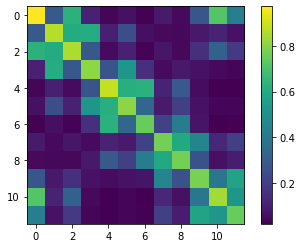

In [34]:
plt.imshow(temporal_dict[101])
plt.colorbar()
plt.show()

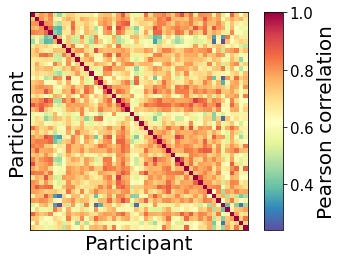

In [45]:
temporal_corrs = np.zeros((len(all_subjects), len(all_subjects)))
for i, sub_i in enumerate(all_subjects):
    mat_i = temporal_dict[sub_i].ravel()
    for j, sub_j in enumerate(all_subjects):
        mat_j = temporal_dict[sub_j].ravel()
        corr = scipy.stats.pearsonr(mat_i, mat_j)[0]
        temporal_corrs[i, j] = corr
        
plt.imshow(temporal_corrs, cmap=cm.Spectral_r)
cbar = plt.colorbar(aspect=12, label="Pearson correlation")
cbar.ax.tick_params(labelsize=15) 
text = cbar.ax.yaxis.label
font = matplotlib.font_manager.FontProperties( size=20)
text.set_font_properties(font)

plt.xlabel("Participant", size=20)
plt.ylabel("Participant", size=20)
plt.xticks([])
plt.yticks([])
plt.savefig("figures/september/temp_corrs.eps")
plt.show()

As we can see, there are relatively high correlations between certain subjects, and certain subjects who are quite ideosyncratic and have temporal matrices which don't correlate strongly with any other. 

Let $R_{ij}$ be the correlation coefficient between subject $i$ and $j$. Now, for every subject $i$, we want to sample from the inverse of the correlation coefficients $R_{i, :}^{-1}$ according to the following distribution

$$p(R_{ij}) = \frac{\exp (R_{ij}^{-1}/\tau) }{\sum_j\exp (R_{i, j}^{-1}/\tau) }$$

where $\tau$ is the inverse temperature parameter. With various settings for $\tau$, we can configure how likely it is that we sample the lowest-correlation temporal matrix we use for scrambling. We want to show that, as $\tau$ increases, we do worse in terms of model fit.




An important thing to keep in mind here is that there are a couple of subjects whose temporal matrices aren't that strongly correlated with all other temporal matrices, so they will be samples very often if we sample with replacement. To solve this, we sample without replacement, and make the scrambling symmetric (so if $i$ is assigned the matrix of $j$, $j$ is also assigned that of $i$), this way we avoid ordering effects.

## 2) Compositional with identity matrix

This model is considerably easier to estimate. We simply take the average of the euclidean kernel and the identity matrix to compute the compositional kernel.

## Getting model predictors
We'll use 10 values for $\tau$ from 0.05 to 3, and sample 10 times from that $\tau$ setting, leaving us with 100 scrambled predictors.

In [6]:
## create some helper variables and the dataframe
num_tau = 10
individual_taus = np.linspace(0.05, 3, num_tau)


taus = np.zeros(num_tau*num_tau)
c = 0
for tau in individual_taus:
    for i in range(num_tau):
        taus[c] = tau
        c+=1

    
#print(taus)
shuffled_temporal_predictors = np.zeros((len(subj), num_tau))
shuffled_temporal_predictors.shape
compositional_identity = np.zeros(len(subj))

In [7]:
from collections import defaultdict
assigned_matrices = {}
for sub_i in all_subjects:
    assigned_matrices[sub_i] = defaultdict(lambda:None)
    


In [8]:
def R_softmax(R_inv, tau):
    return np.exp(R_inv/tau)/np.sum(np.exp(R_inv/tau))

In [9]:

assigned_idx = {}
for i, tau in enumerate(taus):
    assigned_idx[i] = []

for i, sub_i in enumerate(all_subjects):
    for j, tau in enumerate(taus):
        already_assigned = assigned_idx[j]
        if i not in already_assigned:
            already_assigned.append(i)
            available = np.delete(np.arange(len(all_subjects)), np.array(already_assigned))

            R = temporal_corrs[i, available]
            R_inv = 1/R

            p = R_softmax(R_inv, tau)

            assignee_idx = np.random.choice(available, p=p)


            assignee = all_subjects[assignee_idx]

            assigned_matrices[sub_i][j] = temporal_dict[assignee]
            assigned_matrices[assignee][j] = temporal_dict[sub_i]
            already_assigned.append(assignee_idx)
        


        

In [10]:

SR_mixed = np.zeros((len(subj), len(taus)))
comp_identity = np.zeros(len(subj))
### Start loop
subj_counter = -1
last_subj = -1
for i, subj_id in enumerate(subj):
    current_context = contexts[i]
    if subj_id != last_subj:

        subj_counter += 1
        trial_counter = 0
        ### set hyperparameters

        lengthscale = 1.24
        compositional_lengthscale = 2.05
        
        loc = PI_dict[subj_id]

        learning_rate= 0.4125
        learning_rate_compositional =0.01

        lengthscale = 1.24


        context_dict = {}
        context_dict[1] ={"training_idx": [], "rewards": [], "state_rewards" : np.zeros(len(np.arange(12)))} 
        context_dict[2] = {"training_idx": [], "rewards": [], "state_rewards" : np.zeros(len(np.arange(12)))} 
        
        
        #### Here we assign models:

        ### Euclidean

        estimated_euclidean_kernel = RBF(loc, loc, l=lengthscale)
        estimated_euclidean_kernel_comp = RBF(loc, loc, l=compositional_lengthscale)

        ##### weighted
        comp_kernel = (estimated_euclidean_kernel_comp + np.eye(len(estimated_euclidean_kernel_comp)))/2 ## add identity matrix



        #######################################
        ### add observations for this context
        options = [op1[i], op2[i]]
        choice = choices[i]
        reward = rewards[i]

        decision = decisions[i]
        unchosen = 1 - decision
        

        context_dict[current_context]["training_idx"].append(choice)
        context_dict[current_context]["rewards"].append(reward)
        context_dict[current_context]["state_rewards"][choice] = reward



        ## set the last subj_id to the current one
        last_subj = subj_id
        trial_counter += 1


    elif len(context_dict[current_context]["rewards"]) == 0:  # check if participant has been able to make any observations in this context yet 
        # if not then let choice be random, and store observations into context dict

        options = [op1[i], op2[i]]
        choice = choices[i]
        reward = rewards[i]

        decision = decisions[i]
        unchosen = 1 - decision
        


        context_dict[current_context]["training_idx"].append(choice)
        context_dict[current_context]["rewards"].append(reward)
        context_dict[current_context]["state_rewards"][choice] = reward


        trial_counter += 1
        


    else:
        options = [op1[i], op2[i]]

        choice = choices[i]
        decision = decisions[i]
        unchosen = 1 - decision
        reward = rewards[i]




        training_idx = context_dict[current_context]["training_idx"] # the training indices for the gps
        R = copy.copy(context_dict[current_context]["state_rewards"]) # an array with rewards for each state for the SR. We copy so that it doesn't change when we normalize it
        y = np.array(copy.copy(context_dict[current_context]["rewards"]))  # for use in the gp models. we copy this so we can normalize it and convert it into an array without messing with the original set of reward observations

        y_prime = np.append(y, reward)

        if y.std() != 0:
            y = (y- y.mean())/y.std()
            y_prime = (y_prime - y_prime.mean())/y_prime.std()

        else:
            y = (y - y.mean())
            y_prime = (y_prime - y_prime.mean())

        reward_normalized = y_prime[-1]
        
        ## get assigned temporal matrix
        for k, tau in enumerate(taus):
            SR_kernel = assigned_matrices[subj_id][k]
            SR_GP_preds = estimate_GP(SR_kernel, y, training_idx, option_indices=options)
            diff = SR_GP_preds[0] - SR_GP_preds[1]
            SR_mixed[i, k] = diff
            

        comp_preds = estimate_GP(comp_kernel, y, training_idx, option_indices=options)
        comp_diff = comp_preds[0] - comp_preds[1]
        comp_identity[i] = comp_diff


        ### update arrays:
        context_dict[current_context]["training_idx"].append(choice)
        context_dict[current_context]["rewards"].append(reward)
        context_dict[current_context]["state_rewards"][choice] = reward
        
        trial_counter += 1

comp_id_df = pd.DataFrame(comp_identity)
comp_id_df.to_csv("param_fits/compositional_identity.csv", index=False)
SR_mixed_df = pd.DataFrame(SR_mixed)
SR_mixed_df.to_csv("param_fits/SR_scrambled.csv", index=False)



See the R file for the results.